In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.8 MB/s eta 0:00:00


In [1]:
from statistics import linear_regression
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
import nltk
import umap
from nltk.help import upenn_tagset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, average_precision_score
import pandas as pd
import numpy as np
import time
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import auc
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import wordnet,subjectivity,stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import re
import string
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

# nltk.download("subjectivity")
# nltk.download('tagsets_json')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('stopwords')

/home/georgefkd/programming/aueb-cs-masters/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [3]:
# print(subjectivity.sents(categories="subj"))
def prepare_data_of_subj_obj():
    print(subjectivity.categories())
# print(subjectivity.sents(categories="subj"))
    subjective_sentences = subjectivity.sents(categories="subj")
    objective_sentences = subjectivity.sents(categories="obj")

    data_with_labels = []
    assert(len(subjective_sentences) == len(objective_sentences))
    for obj_sentence,subj_sentence in zip(objective_sentences,subjective_sentences):
        data_with_labels.append({"label":"obj","sentence":obj_sentence})
        data_with_labels.append({"label":"subj","sentence":subj_sentence})

    # print(upenn_tagset()) -> Μέρη του λόγου σε προτάσεις και σε τι κλήση κλπ βρίσκονται
    lemmatizer = WordNetLemmatizer()
    tagger = PerceptronTagger()
    docs = []
    labels = []
    for doc in tqdm(data_with_labels):
        sentence = " ".join(doc["sentence"])
        label = doc["label"]
        document = re.sub(r'\W', ' ', str(sentence))

        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        document = re.sub(r'\s+', ' ', document, flags=re.I)

        document = document.lower()

        document = document.split()

        doc_pos = [x[1] for x in tagger.tag(document)]

        document = \
            [lemmatizer.lemmatize(token, pos=nltk_pos_tagger(pos_tag)) \
                if nltk_pos_tagger(pos_tag) != None else lemmatizer.lemmatize(token) \
            for token, pos_tag in zip(document, doc_pos)]

        document = ' '.join(document)

        docs.append(document)
        value_of_label = 0 if label == "subj" else 1
        labels.append(value_of_label)
        # labels.append(label)
    # print(docs)
    print(len(subjective_sentences),len(objective_sentences))
    return docs,labels

In [4]:
docs,labels = prepare_data_of_subj_obj()
train_sentences,test_sentences,train_labels,test_labels = train_test_split(docs, labels, test_size=0.3, random_state=1924)

print(len(train_sentences), len(train_labels))
print(len(test_sentences), len(test_labels))

print(train_sentences[0], "**", train_labels[0])
print(test_sentences[0], "--", test_labels[0])
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2),
    max_features = 5000,
    #tf -> 1 + log(tf).
    sublinear_tf = True,
    stop_words = stopwords.words('english'))

x_train_tfidf = vectorizer.fit_transform(train_sentences)
x_test_tfidf = vectorizer.transform(test_sentences)

print(vectorizer.get_feature_names_out()) # print(vectorizer.get_feature_names()) --> for older versions

['obj', 'subj']


100%|██████████| 10000/10000 [00:06<00:00, 1635.27it/s]


5000 5000
7000 7000
3000 3000
ultimately she discover that what appear on the surface to be true quite often be not ** 1
with it dog hollywood naturalism and the inexorable passage of it character toward sainthood windtalker be nothing but sticky sweet soap -- 0
['000' '10' '10 minute' ... 'zhao' 'zombie' 'zone']


Shape:  (7000, 2)


<Axes: title={'center': 'UMAP Reduction'}>

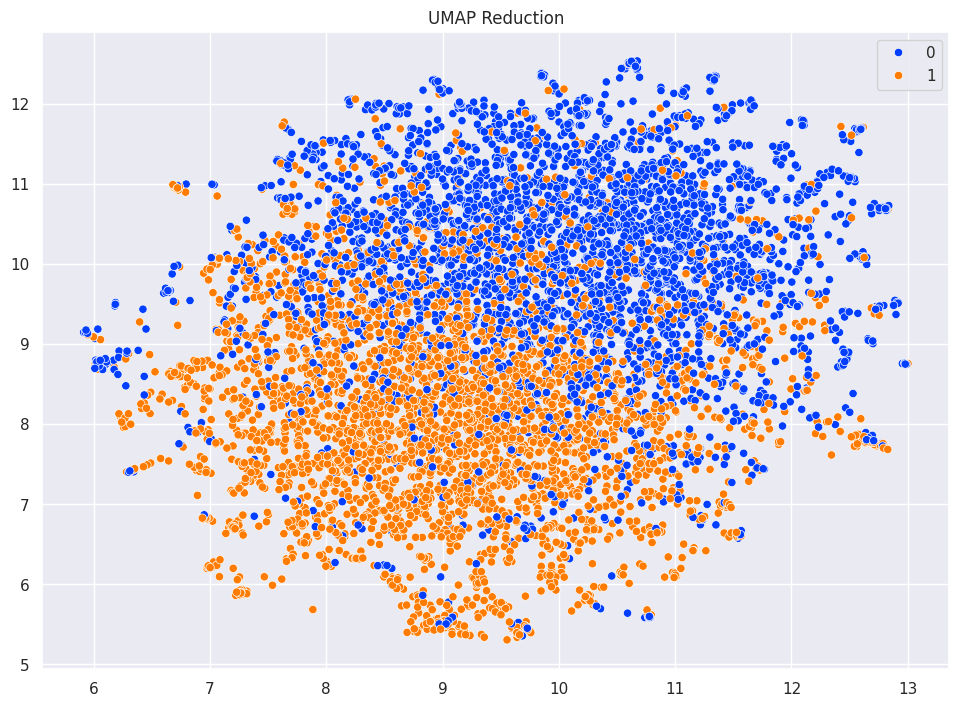

In [5]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
reducer = umap.UMAP(n_components=2)
x_train_embedding = reducer.fit_transform(x_train_tfidf)
print('Shape: ', x_train_embedding.shape)


plt.figure()
plt.title('UMAP Reduction')
sns.scatterplot(x=x_train_embedding[:,0],
                y=x_train_embedding[:,1],
                hue=train_labels,
                legend='full',
                palette=palette)

#Checking how a simple model performs

Training took: 0.001775503158569336 seconds 

Train accuracy: 50.71%
Test accuracy: 48.33% 


Confusion Matrix for test data:
Classification report for baseline
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.48      0.65      3000

    accuracy                           0.48      3000
   macro avg       0.50      0.24      0.33      3000
weighted avg       1.00      0.48      0.65      3000



/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

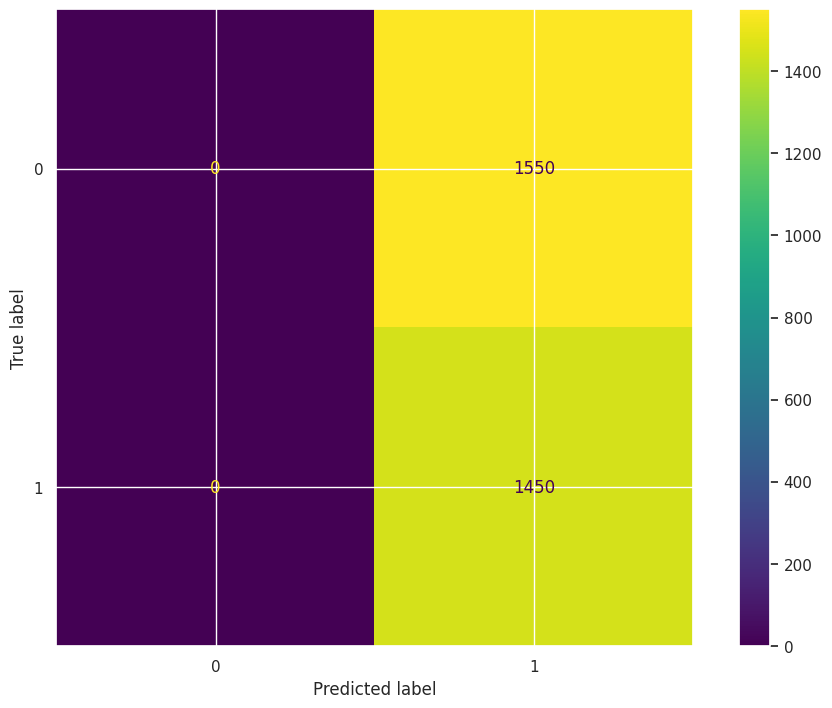

In [6]:
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, train_labels)
print("Training took: {} seconds \n".format(time.time() - start_time))

predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(train_labels, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(test_labels, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

confusion_plot = ConfusionMatrixDisplay

confusion_plot.from_estimator(estimator=baseline,
                              X=x_test_tfidf,
                              y=test_labels,
                              values_format = '.0f')
print("\nConfusion Matrix for test data:")




print("Classification report for baseline")
results = classification_report(predictions_test, test_labels)
print(results)

In [9]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
start_time = time.time()
dummy_classifier.fit(x_train_tfidf, train_labels)
finish_time = time.time()
var_float_total_time = finish_time - start_time
print("Completion Time for Training: {0:.2f} seconds".format(start_time))
y_predictions_training = dummy_classifier.predict(x_train_tfidf)
y_predictions_test = dummy_classifier.predict(x_test_tfidf)
print("Predicted Train Labels Length is: ", len(y_predictions_training))
print("Predicted Test Labels Length is: ", len(y_predictions_test))
array_support_train_data = precision_recall_fscore_support(train_labels, y_predictions_training, average = None)
array_support_test_data = precision_recall_fscore_support(test_labels, y_predictions_test, average = None)


print("Dummy Classifier in Training Data")
print(classification_report(y_predictions_training, train_labels,target_names=["subj","obj"]))
print("Dummy Classifier in Test Data")
print(classification_report(y_predictions_test, test_labels,target_names=["subj","obj"]))

Completion Time for Training: 1734473415.58 seconds
Predicted Train Labels Length is:  7000
Predicted Test Labels Length is:  3000
Dummy Classifier in Training Data
              precision    recall  f1-score   support

        subj       0.00      0.00      0.00         0
         obj       1.00      0.51      0.67      7000

    accuracy                           0.51      7000
   macro avg       0.50      0.25      0.34      7000
weighted avg       1.00      0.51      0.67      7000

Dummy Classifier in Test Data
              precision    recall  f1-score   support

        subj       0.00      0.00      0.00         0
         obj       1.00      0.48      0.65      3000

    accuracy                           0.48      3000
   macro avg       0.50      0.24      0.33      3000
weighted avg       1.00      0.48      0.65      3000



/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [12]:
log_regression = LogisticRegression(solver="liblinear")
start_time = time.time()
log_regression.fit(x_train_tfidf, train_labels)
finish_time = time.time()
total_time = finish_time - start_time
print("Completion Time for Training: {0:.2f} seconds".format(total_time))
y_predictions_train = log_regression.predict(x_train_tfidf)
y_predictions_test = log_regression.predict(x_test_tfidf)
print("Predicted Train Labels Length is: ", len(y_predictions_train))
print("Predicted Test Labels Length is: ", len(y_predictions_test))
array_support_train_data = precision_recall_fscore_support(train_labels, y_predictions_train, average = None)
array_support_test_data = precision_recall_fscore_support(test_labels, y_predictions_test, average = None)

print("====For Logistic Regression ======")
print("F-Score")
print("For Training Data")
print(classification_report(y_predictions_training, train_labels,target_names=["subj","obj"]))
print("For Testing Data")
print(classification_report(y_predictions_test, test_labels,target_names=["subj","obj"]))


Completion Time for Training: 0.01 seconds
Predicted Train Labels Length is:  7000
Predicted Test Labels Length is:  3000
====For Logistic Regression ======
F-Score
For Training Data
              precision    recall  f1-score   support

        subj       0.00      0.00      0.00         0
         obj       1.00      0.51      0.67      7000

    accuracy                           0.51      7000
   macro avg       0.50      0.25      0.34      7000
weighted avg       1.00      0.51      0.67      7000

For Testing Data
              precision    recall  f1-score   support

        subj       0.88      0.89      0.89      1545
         obj       0.88      0.88      0.88      1455

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

[0.00938715 0.01215822 0.01732691 ... 0.97748849 0.97857549 0.98059502] <class 'numpy.ndarray'>


/home/georgefkd/programming/aueb-cs-masters/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro avg AUC 0.30628694448519744
Macro average recall [0.8857953281423805, 0.8857730812013348, 0.8855172413793104, 0.885472747497219, 0.8854505005561735, 0.8854282536151279, 0.8851946607341491, 0.8851724137931034, 0.8851501668520578, 0.8850834260289211, 0.885027808676307, 0.8848720800889878, 0.8848275862068966, 0.8847385984427141, 0.8847274749721914, 0.8847052280311457, 0.8846829810901001, 0.8846607341490546, 0.8846607341490544, 0.8846273637374861, 0.8845717463848721, 0.8845494994438265, 0.8844493882091213, 0.8844271412680756, 0.88440489432703, 0.88440489432703, 0.8843937708565073, 0.8843826473859844, 0.8843826473859844, 0.8843381535038932, 0.8843381535038932, 0.8843159065628476, 0.8843159065628476, 0.8843047830923247, 0.8842936596218021, 0.8842936596218021, 0.8842825361512792, 0.8842714126807564, 0.8842714126807564, 0.8842491657397108, 0.8842491657397108, 0.8842269187986652, 0.8842046718576195, 0.8841268075639599, 0.8841045606229143, 0.8840823136818687, 0.8840823136818687, 0.88407119

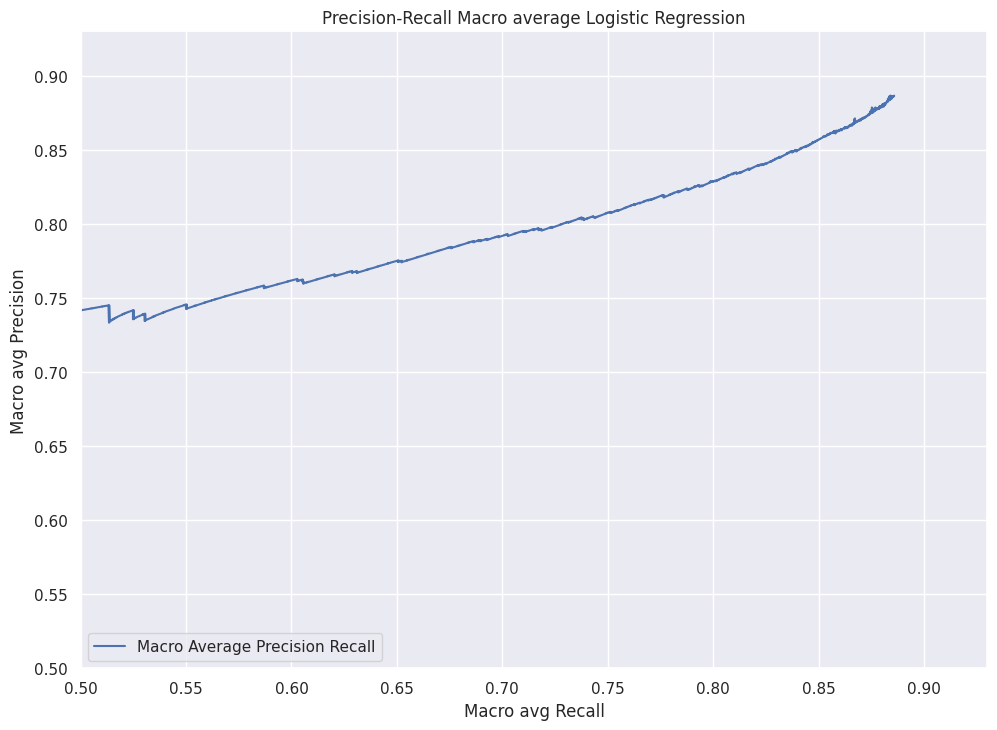

Area is:  0.9500080114505707


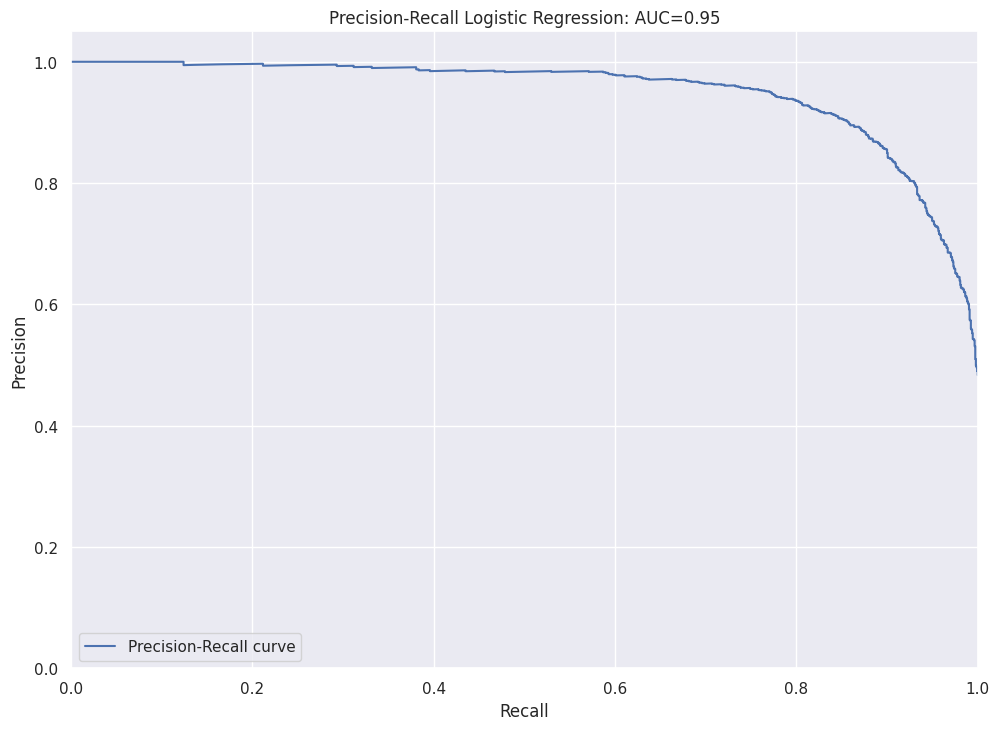

In [13]:
np.seterr(all='ignore')
estimators = {'Logistic Regression':log_regression}

macro_avg_prec_recall = 0
for (name,estimator) in estimators.items():

    model = estimator
    pred = model.predict_proba(x_test_tfidf)

    precision, recall, thresholds = precision_recall_curve(test_labels, pred[:,1])

    macro_avg_recall = []
    macro_avg_precision = []
    print(thresholds,type(thresholds))
    for t in thresholds:
        precisions = precision_score(test_labels, pred[:,1] > t,average=None,zero_division="warn")
        recalls = recall_score(test_labels,pred[:,1] > t,average=None,zero_division="warn")
        avg_precision = np.average(precisions)
        avg_recalls = np.average(recalls)
        macro_avg_precision.append(avg_precision)
        macro_avg_recall.append(avg_recalls)

    new_prec = []
    new_recall = []
    while(len(macro_avg_recall) > 0):
        current_max,current_index = max((value,index) for index,value in enumerate(macro_avg_recall))
        new_recall.append(current_max.item())
        new_prec.append(macro_avg_precision[current_index].item())
        macro_avg_recall.remove(current_max)
    print("Macro avg AUC",auc(new_recall,new_prec))

    print("Macro average recall",new_recall)
    print("Macro average precision",new_prec)
    # macro_avg_area = auc(macro_avg_recall,macro_avg_precision)
    plt.figure()
    plt.plot(new_recall,new_prec,label="Macro Average Precision Recall")
    plt.xlabel("Macro avg Recall")
    plt.ylabel("Macro avg Precision")
    plt.ylim([0.5, 0.93])
    plt.xlim([0.5, 0.93])
    plt.title(f'Precision-Recall Macro average {name}')
    plt.legend(loc="lower left")
    plt.show()

    area = auc(recall, precision)
    print("Area is: ",area)

    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
    plt.legend(loc="lower left")
    plt.show()




In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

#Data Cross Validation

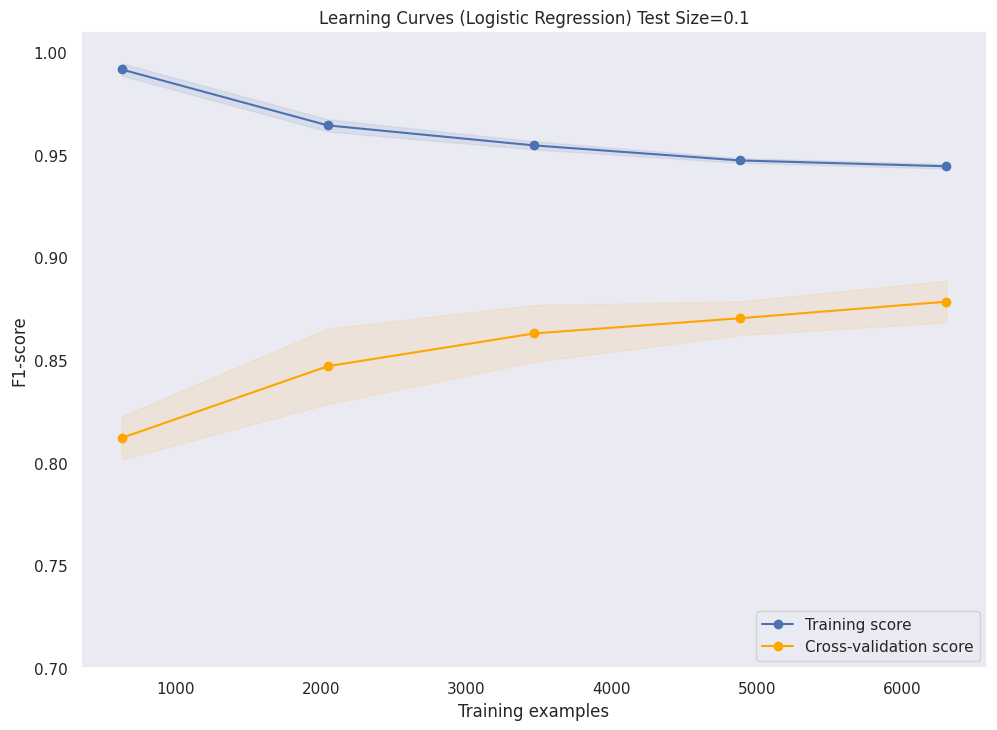

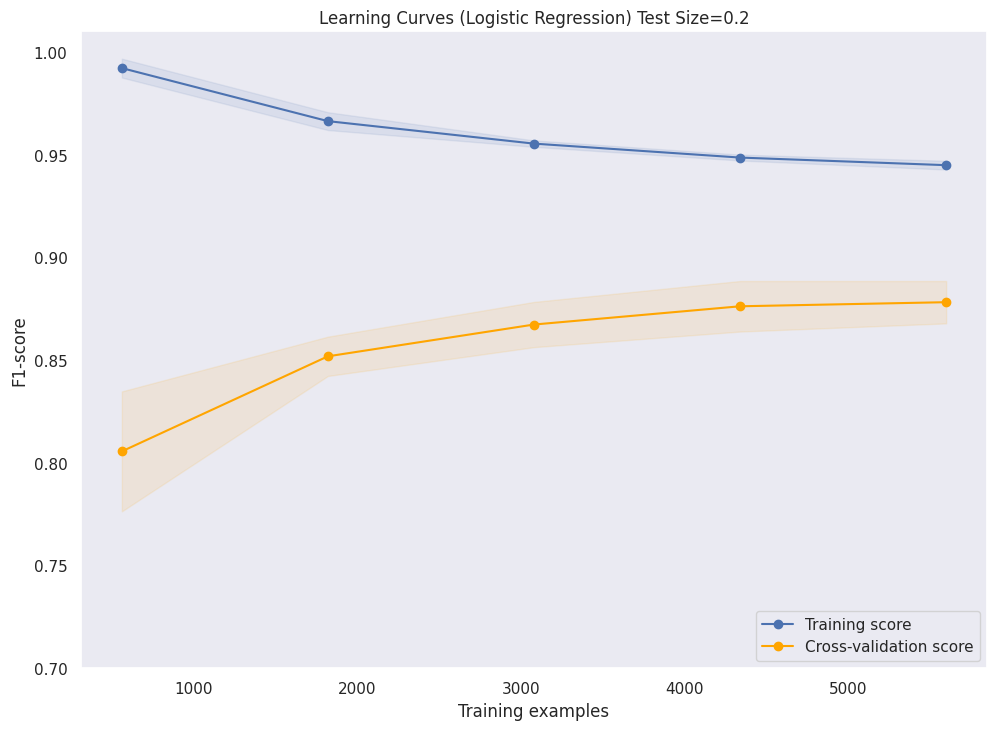

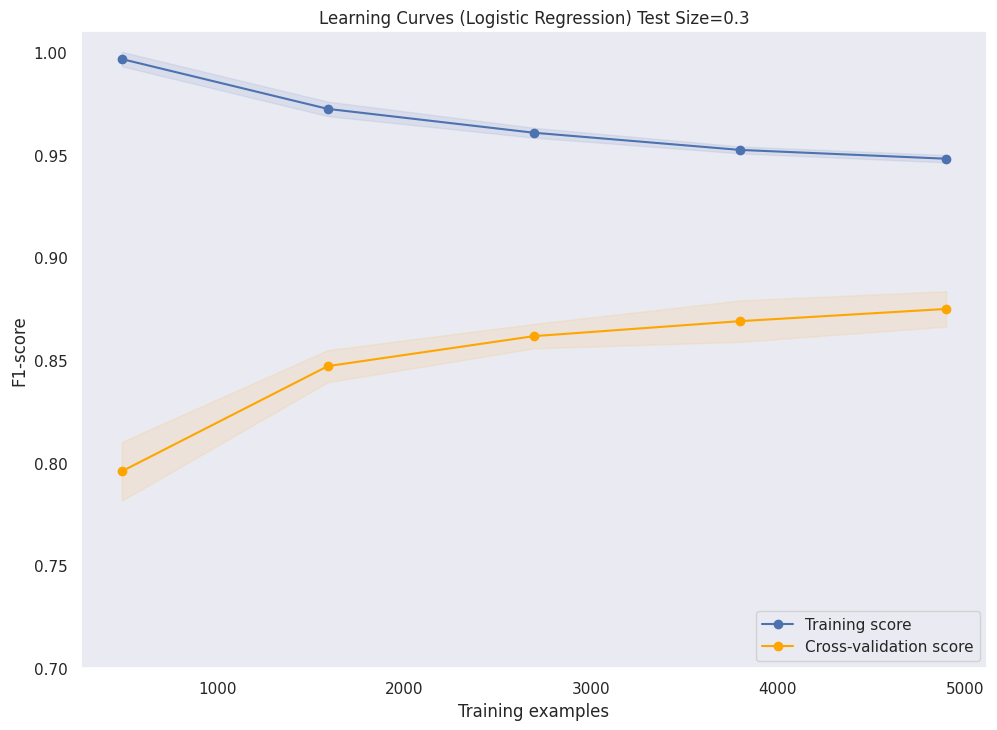

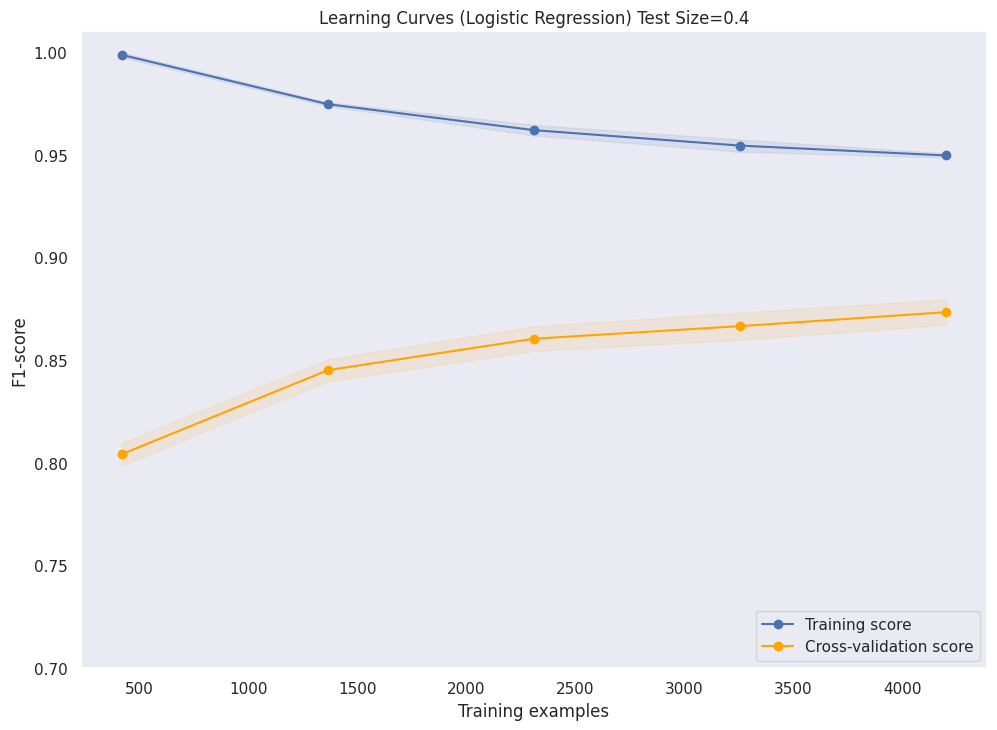

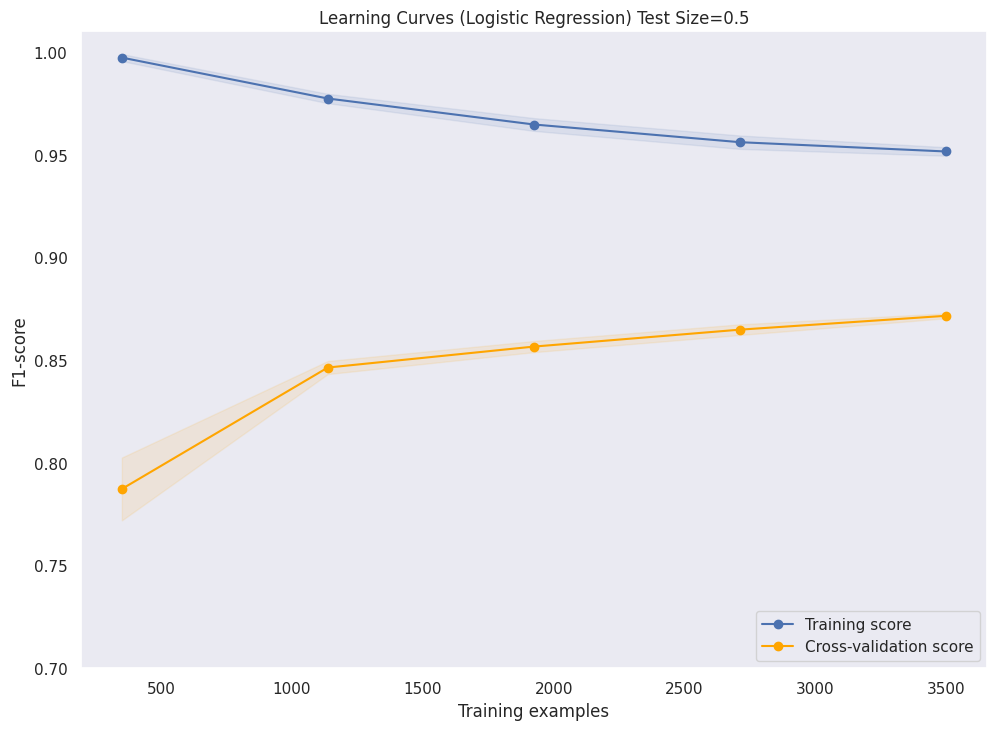

In [19]:
test_sizes = [0.1,0.2,0.3,0.4,0.5]
for test_sz in test_sizes:
  x,y = x_train_tfidf,train_labels
  title = f"Learning Curves (Logistic Regression) Test Size={test_sz}"
  cv = ShuffleSplit(n_splits=5, test_size = test_sz , random_state=1924)
  estimator = log_regression
  plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [16]:
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

In [17]:
grid_params = {
  'lr__solver': ['liblinear'],
  'lr__C': np.linspace(0.1, 1, 10),
  'lr__max_iter': [50, 100, 200],
  'tfidf_vectorizer__min_df': np.linspace(0.01, 0.1, 10),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],
  'tfidf_vectorizer__sublinear_tf': [True,False],
}

In [ ]:
clf = GridSearchCV(lr_pipeline, grid_params,scoring='f1',cv=3, n_jobs=-1)
start_time = time.time()
clf.fit(train_sentences, train_labels)
print("GridSearchCV took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

KeyboardInterrupt: 

In [18]:
clf2 = RandomizedSearchCV(lr_pipeline, grid_params, scoring='f1', cv=3, n_jobs=-1, n_iter=100)
start_time = time.time()
clf2.fit(train_sentences, train_labels)
print("RandomizedSearchCV took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", clf2.best_score_)
print("Best Params: ", clf2.best_params_)

RandomizedSearchCV took: 8.61799669265747 seconds 

Best Score:  0.8485260155998061
Best Params:  {'tfidf_vectorizer__sublinear_tf': True, 'tfidf_vectorizer__ngram_range': (1, 3), 'tfidf_vectorizer__min_df': 0.01, 'lr__solver': 'liblinear', 'lr__max_iter': 100, 'lr__C': 1.0}
